In [157]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import sys
import torch.linalg as linalg

In [158]:
def base_ortogonale(a):
    q,r=torch.linalg.qr(a,mode='reduced') 
    l = []
    eps = 1e-5
    #l è la lista degli indici dei vettori utili
    for i in range(r.size()[0]):
        if r[i,:].norm() > eps:
            l.append(i)
    base_ortogonale=q[:,l ]
    return base_ortogonale

In [159]:
dataset = torch.tensor([[0.,8.],[1.,8.],[2.,8.],[3.,8.],[4.,8.],
                        [0.,7.],[1.,7.],[2.,7.],[3.,7.],[4.,7.],
                        [0.,6.],[1.,6.],[2.,6.],[3.,6.],[4.,6.],
                        [0.,5.],[1.,5.],[2.,5.],[3.,5.],[4.,5.],
                        [0.,4.],[1.,4.],[2.,4.],[3.,4.],[4.,4.],
                        [0.,3.],[1.,3.],[2.,3.],[3.,3.],[4.,3.],
                        [0.,2.],[1.,2.],[2.,2.],[3.,2.],[4.,2.],
                        [0.,1.],[1.,1.],[2.,1.],[3.,1.],[4.,1.]])

labels = torch.tensor(  [0.,0.,0.,0.,0.,
                         0.,0.,0.,0.,0.,
                         0.,0.,0.,0.,0.,
                         0.,0.,1.,0.,0.,
                         1.,1.,1.,0.,1.,
                         1.,1.,0.,1.,1.,
                         1.,1.,1.,1.,1.,
                         1.,1.,1.,1.,1.])

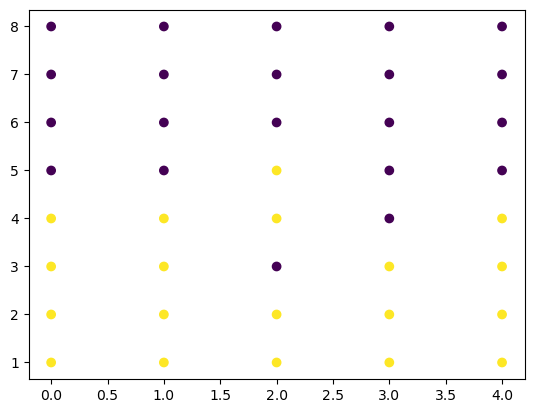

In [160]:
plt.scatter([p[0] for p in dataset],[p[1] for p in dataset], c=labels,cmap = 'viridis')
plt.show()

In [161]:
train_data = []
train_data0 = []
train_data1 = []

for i in range(len(dataset)):
   train_data.append([dataset[i], labels[i]])
   if labels[i] == 0:
      train_data0.append([dataset[i], labels[i]])
   elif labels[i] == 1:
      train_data1.append([dataset[i], labels[i]])


## Modello 1

Caso semplice di classificazione binaria con Binary Cross-Entropy come loss

3 layer:
- $W_0 \space (2 \times 10)$
- $W_1 \space (10 \times 10)$
- $W_2 \space (10 \times 1)$

Funzioni non lineari nascoste: $ReLU$

Funzioni non lineari in uscita: $Sigmoid$

In sintesi:

$$y = \sigma(W_2^T*R(W_1^T*R(W_0^T*x)))$$

In [162]:
class Modello1(nn.Module):
    '''
        Implementazione modello a 3 strati semplice
    '''
    def __init__(self, input_size, output_size, hidden_size):
        super(Modello1, self).__init__()
        self.W0 = torch.nn.Linear(input_size, hidden_size)
        self.W1 = torch.nn.Linear(hidden_size, hidden_size)
        self.W2 = torch.nn.Linear(hidden_size, output_size)

        self.R1 = torch.nn.ReLU()
        self.R2 = torch.nn.ReLU()

        self.S = torch.nn.Sigmoid()
    
    def forward(self, x):
        '''
            Modello a 3 strati semplice per classificazione binaria
        '''
        k = self.W0(x)
        z = self.R1(k)

        u = self.W1(z)
        v = self.R2(u)

        l = self.W2(v)
        y = self.S(l)
        
        return y

Text(0.5, 1.0, 'Decision 200 epochs')

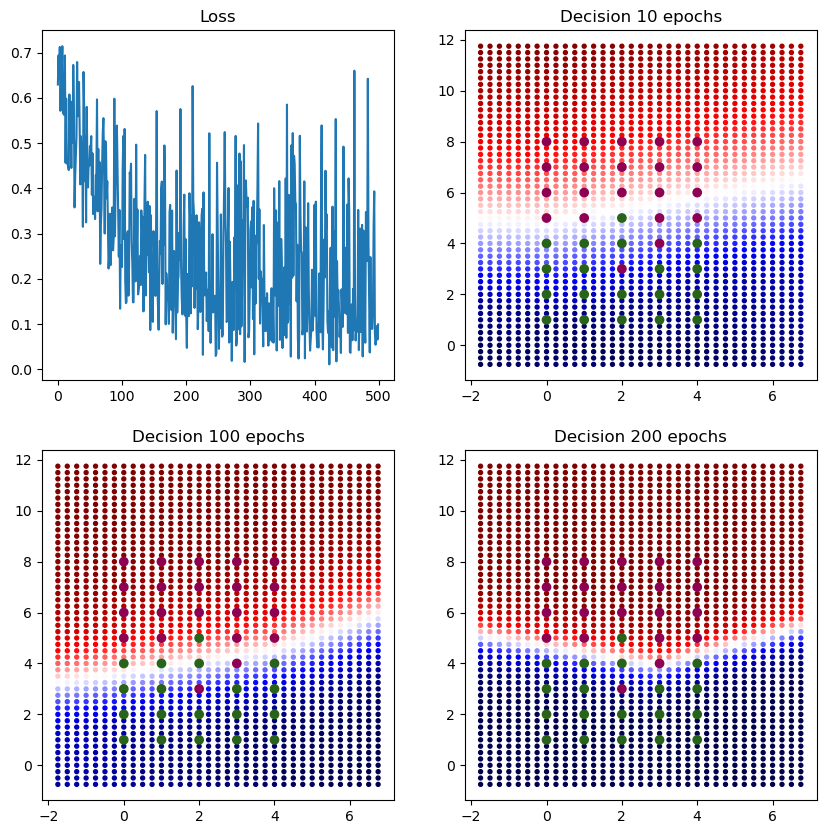

In [163]:
torch.manual_seed(4242)
e_list = []

dl = torch.utils.data.DataLoader(train_data, batch_size = 8, shuffle = True)
modello = Modello1(2,1,10)
loss = torch.nn.BCELoss()
optimizer = torch.optim.Adam(modello.parameters())

epoch = range(500)
fig, plot = plt.subplots(2, 2, figsize=(10, 10))

for e in epoch:
    for x,y in dl:
        y_pred = modello(x)
        error = loss(y_pred, y.unsqueeze(1))

        optimizer.zero_grad()
        error.backward()
        optimizer.step()
        
    e_list.append(error.detach().numpy())
    if e == 10:
        points = [[x/4, y/4, modello(torch.tensor([x/4*1.0,y/4*1.0]))] for x in range(-7,7*4) for y in range(-3,12*4)]
        plot[0,1].scatter([p[0] for p in points], [p[1] for p in points], c = [1 - p[2].detach().numpy() for p in points], s=8, cmap = "seismic")
        plot[0,1].scatter([p[0] for p in dataset],[p[1] for p in dataset], c=labels,cmap = 'PiYG')
        plot[0,1].set_title("Decision 10 epochs")
    if e == 100:
        points = [[x/4, y/4, modello(torch.tensor([x/4*1.0,y/4*1.0]))] for x in range(-7,7*4) for y in range(-3,12*4)]
        plot[1,0].scatter([p[0] for p in points], [p[1] for p in points], c = [1 - p[2].detach().numpy() for p in points], s=8, cmap = "seismic")
        plot[1,0].scatter([p[0] for p in dataset],[p[1] for p in dataset], c=labels,cmap = 'PiYG')
        plot[1,0].set_title("Decision 100 epochs")

plot[0,0].plot([x for x in range(len(e_list))], e_list, label = "Loss")
plot[0,0].set_title("Loss")


points = [[x/4, y/4, modello(torch.tensor([x/4*1.0,y/4*1.0]))] for x in range(-7,7*4) for y in range(-3,12*4)]
plot[1,1].scatter([p[0] for p in points], [p[1] for p in points], c = [1 - p[2].detach().numpy() for p in points], s=8, cmap = "seismic")
plot[1,1].scatter([p[0] for p in dataset],[p[1] for p in dataset], c=labels, cmap = 'PiYG')
plot[1,1].set_title("Decision 200 epochs")

In [164]:
# Rosso -> Non entrano
# Blu -> Entrano

# Viola -> Non possono entrare [0]
# Verde -> Possono entrare [1]

## Modello 2

Il seguente modello consiste in un'espansione del precedente:

Viene aggiunto un layer che in fase di Forward propagation, si comporta come se non ci fosse, mentre in fase di Backward propagation, si comporta in maniera diversa, solo se stiamo utilizzando una loss secondaria. Il modello da simulare e' il seguente:

Supponendo che $u = W_1^T * z$ e che $v = R(u)$, vogliamo inserire una rete tale che:
$$ v = R(W_1^T*z + P_{z}^{(y\equiv 0)}* u * W_1') $$

In questa maniera, l'errore della loss secondaria, si propaga solo sulle componenti ortogonali di z

In altre parole, serve a far si che il miglioramento della loss secondaria, non influisca affatto sulla loss primaria

In [167]:
class Modello2(nn.Module):
    '''
        Implementazione modello visto con Fiaschi
    '''
    def __init__(self, input_size, output_size, hidden_size):
        super(Modello2, self).__init__()

        self.W0 = torch.nn.Linear(input_size, hidden_size)
        self.W1 = torch.nn.Linear(hidden_size, hidden_size)
        self.W2 = torch.nn.Linear(hidden_size, output_size)

        self.R1 = torch.nn.ReLU()
        self.R2 = torch.nn.ReLU()

        # self.Sig = torch.nn.Sigmoid()
    
        self.optimizer = torch.optim.Adam(self.parameters())

        self.loss = torch.nn.BCEWithLogitsLoss()
        
    def forwardL1(self, x):
        '''
            Modello a 3 strati semplice per classificazione binaria
            
            S(W2 * R2(W1 * R1(W0 * x))) 
        '''
        
        layer1 = self.R1(self.W0(x))

        # W1 diretta
        v = self.W1(layer1)
        layer2 = self.R2(v)

        z = self.W2(layer2)
        # y = self.Sig(z)
        return z, v # Ritorno sa y che le z (che mi servono per la proiezione)

    def forwardL2(self, x):
        '''
            Modello a 3 strati semplice per classificazione binaria
            
            S(W2 * R2( u))
        '''
        k = self.W0(x)
        z = self.R1(k)
        u = self.W1(z)

        # Blocco 2 - Proiezione di u sullo spazio ortogonale a L1_u delle sole (y == 0)
        u_p = self._Projection(u, self.save_u)
        

        v = self.R2(u_p)

        l = self.W2(v)
        # y = self.Sig(l)
        return l

    def _Projection(self, u, u_0):
        q, r = torch.linalg.qr(u_0.T, mode = 'reduced')
        
        diag = torch.diagonal(r)
        mask = torch.where(diag != 0)
        base = q.T[mask] # Base indipendenti, normalizzate
        # BASE Nx10
        P_ort = self._orthogonal_base(base)
        # Project u on them and return it
        return torch.mm(u, P_ort)

    def _orthogonal_base(self, A):
        # A = Nx10
        A = A.T
        # A = 10xN
               
        AAT = torch.matmul(A.T, A)
        # AAT = NxN

        AAT_INV = torch.linalg.solve(AAT, torch.eye(AAT.shape[0])) 
        # AAT_INV = NxN

        P_a = torch.matmul(A, AAT_INV) 
        # P_a = 10xN
        P_a = torch.matmul(P_a, A.T) 
        # P_a = 10x10
        P = torch.eye(P_a.shape[0]) - P_a 

        return P


    def forward(self, x, mode = 'inference'):
        if mode == 'inference' or mode == 'L1':
            return self.forwardL1(x)
        if mode == 'L2':
            return self.forwardL2(x)

    def train(self, dl, mode = 'L1'):
        for x,y in dl:
            self.optimizer.zero_grad()

            if mode == 'L1':
                y_pred, _ = modello(x, mode)
            elif mode == 'L2':
                y_pred = modello(x, mode)
            
            e = self.loss(y_pred, y.unsqueeze(1))
            e.backward()
                
            self.optimizer.step()
        return e.detach().numpy()

    def gen_u_y0(self, dl):
        self.save_u = None
        with torch.no_grad():
            for x,y in dl:  
                _, u = modello(x)
                print(f'{u=}')
                u = u[torch.where(y == 0)]
                print(f'{u=}\n{y=}')
                print('#####')
                if self.save_u is None:
                    self.save_u = u.clone().detach()
                else:
                    self.save_u = torch.cat((self.save_u, u.clone().detach()), dim = 0)

In [170]:
torch.manual_seed(4242)
modello = Modello2(2,1,20)
dl0 = torch.utils.data.DataLoader(train_data0, batch_size = 8, shuffle = True)
dl1 = torch.utils.data.DataLoader(train_data1, batch_size = 8, shuffle = True)

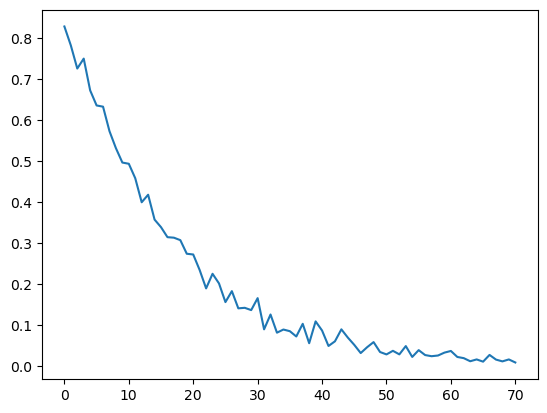

In [171]:
e = 1
err = []
while e > 1e-2:
    e = modello.train(dl0) # Dentro dl ci deveno essere solo y == 0, ed usiamo BCELogitsLoss
    err.append(e) 

plt.plot([x for x in range(len(err))], err, label = "Loss")
plt.show()

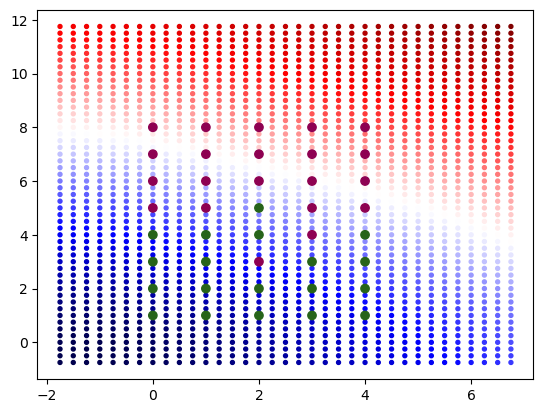

In [172]:
with torch.no_grad():
    points = [[x/4, y/4,modello(torch.tensor([x/4*1.0,y/4*1.0]))] for x in range(-7,7*4) for y in range(-3,12*4)]
    plt.scatter([p[0] for p in points], [p[1] for p in points], c = [1 - p[2][0].detach().numpy() for p in points], s=8, cmap = "seismic")
    plt.scatter([p[0] for p in dataset],[p[1] for p in dataset], c=labels,cmap = 'PiYG')
    plt.show()
    print()

u=tensor([[ 5.3739e+00, -2.3001e-01, -1.8119e+00, -3.0346e-01, -6.0114e-01,
         -1.7836e+00, -1.8203e+00, -7.9826e-01,  5.7149e+00, -5.7731e-01,
         -1.8211e-01, -1.7737e+00, -2.0109e+00, -5.3181e-01, -1.7429e+00,
         -2.2587e+00, -3.8027e-01, -3.7473e+00,  4.1917e+00, -1.7452e+00],
        [ 3.8377e+00, -2.5609e-01, -1.2490e+00, -2.0587e-01, -1.0721e+00,
         -9.9453e-01, -1.3349e+00, -1.7475e-01,  3.5317e+00, -1.1374e+00,
         -1.0670e-01, -1.1493e+00, -2.4853e+00, -1.6954e-04, -4.9033e-02,
         -1.6967e+00, -1.3830e-01, -2.5572e+00,  3.6824e+00, -1.4931e+00],
        [ 3.8859e+00, -2.3042e-01, -1.2510e+00, -2.1168e-01, -5.9847e-01,
         -1.2770e+00, -1.4071e+00, -4.9592e-01,  4.0501e+00, -6.2282e-01,
         -2.0414e-01, -1.2460e+00, -1.6108e+00, -2.9619e-01, -1.0137e+00,
         -1.6310e+00, -2.1451e-01, -2.7463e+00,  3.1797e+00, -1.2632e+00],
        [ 2.7828e+00, -2.8777e-01, -8.5708e-01, -1.3989e-01, -8.1766e-01,
         -8.1245e-01, -1.0431e+00

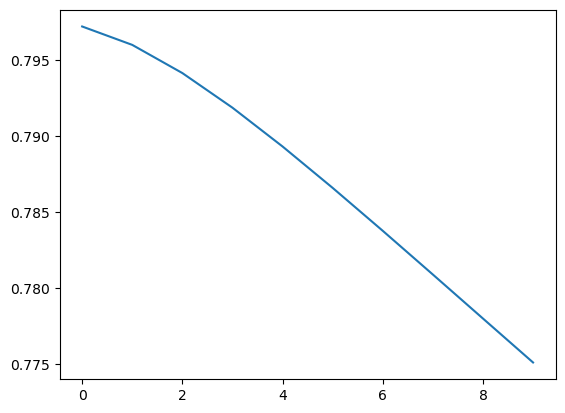

In [173]:
err = []
modello.gen_u_y0(dl0)

for _ in range(10):
    e = modello.train(dl1, 'L2')
    err.append(e)

plt.plot([x for x in range(len(err))], err)

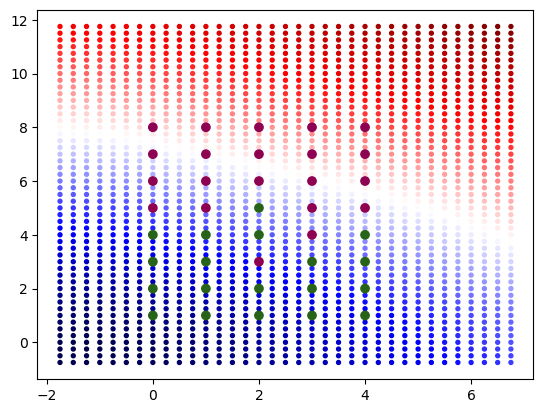

In [174]:
with torch.no_grad():
    points = [[x/4, y/4, modello(torch.tensor([x/4*1.0,y/4*1.0]))] for x in range(-7,7*4) for y in range(-3,12*4)]
    plt.scatter([p[0] for p in points], [p[1] for p in points], c = [1 - p[2][0].detach().numpy() for p in points], s=8, cmap = "seismic")
    plt.scatter([p[0] for p in dataset],[p[1] for p in dataset], c=labels,cmap = 'PiYG')
    plt.show()
    print()